# 【第47回_Beginner限定コンペ】医療保険の費用帯予測
- **目的**： 医療データを使って保険の費用帯を予測しよう！
- **評価指標**：「F1score」（マクロ平均）
- **目的変数**： **"charge"**（価格帯0（低）、1（中）、2（高））

## メモ
- **データ概要**
 - **訓練データ**： 1600行、欠損値なし
 - **テストデータ**： 400行、欠損値なし
- **EDA**
 - 目的変数
   - "0"が1256件、それ以外が100件ずつほどの規模感
   - "age"で層別した結果、関連性はあまり強くはなさそう
   - "bmi"で層別したが、関係性はありそう（目的変数によって分布の山が異なる）
- **モデル**
 - **LightGBM ?**（分類問題なので）

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = ""

df_train = pd.read_csv(INPUT_DIR + "train.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submit.csv")
df_train.head()

,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0
1,1,41,male,29.798725,1,no,southwest,0
2,2,28,male,32.722029,0,yes,northwest,1
3,3,20,female,38.429831,2,no,southeast,0
4,4,45,female,29.641854,1,no,northwest,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1600 non-null   int64  
 1   age       1600 non-null   int64  
 2   sex       1600 non-null   object 
 3   bmi       1600 non-null   float64
 4   children  1600 non-null   int64  
 5   smoker    1600 non-null   object 
 6   region    1600 non-null   object 
 7   charges   1600 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 100.1+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        400 non-null    int64  
 1   age       400 non-null    int64  
 2   sex       400 non-null    object 
 3   bmi       400 non-null    float64
 4   children  400 non-null    int64  
 5   smoker    400 non-null    object 
 6   region    400 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 22.0+ KB


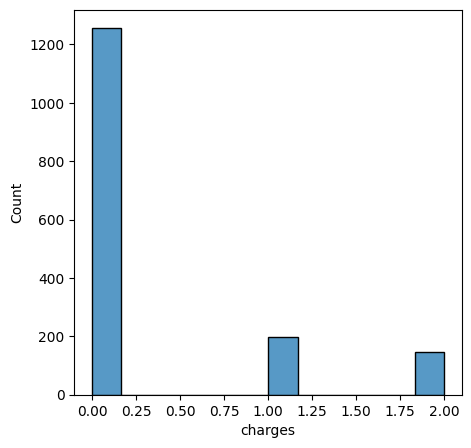

平均値：0.30625


In [ ]:
# 目的変数のヒストグラム
plt.figure(figsize=(5, 5))
sns.histplot(data=df_train, x='charges')
plt.show()
# 目的変数の平均値と中央値を求める
y_mean=df_train["charges"].mean()
print(f"平均値：{y_mean}")

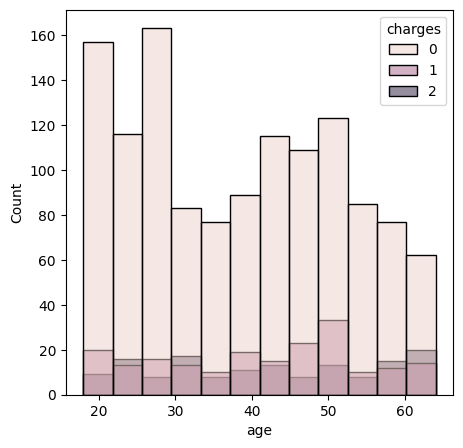

   charges       mean  count
0        0  38.260350   1256
1        1  41.151515    198
2        2  42.280822    146


In [ ]:
# 目的変数で層別した説明変数（age）
plt.figure(figsize=(5, 5))
sns.histplot(data=df_train, x='age', hue='charges')
plt.show()
# chargesごとにageの平均値と総数を求める
charges_grouped = df_train.groupby('charges')['age'].agg(['mean', 'count']).reset_index()
# 結果の表示
print(charges_grouped)

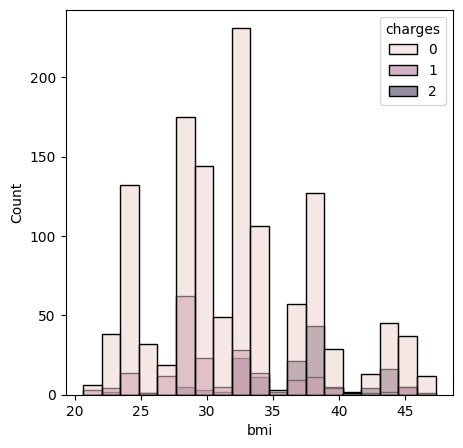

   charges       mean  count
0        0  32.156091   1256
1        1  30.813295    198
2        2  36.917257    146


In [ ]:
# 目的変数で層別した説明変数（bmi）
plt.figure(figsize=(5, 5))
sns.histplot(data=df_train, x='bmi', hue='charges')
plt.show()
# chargesごとにageの平均値と総数を求める
charges_grouped = df_train.groupby('charges')['bmi'].agg(['mean', 'count']).reset_index()
# 結果の表示
print(charges_grouped)

In [ ]:
# カテゴリカル変数をダミー化
df_train_dummies = pd.get_dummies(df_train, drop_first=True, dtype=int)
df_train_dummies.head()

,id,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,26,32.665465,3,0,1,0,0,1,0
1,1,41,29.798725,1,0,1,0,0,0,1
2,2,28,32.722029,0,1,1,1,1,0,0
3,3,20,38.429831,2,0,0,0,0,1,0
4,4,45,29.641854,1,0,0,0,1,0,0


<Axes: >

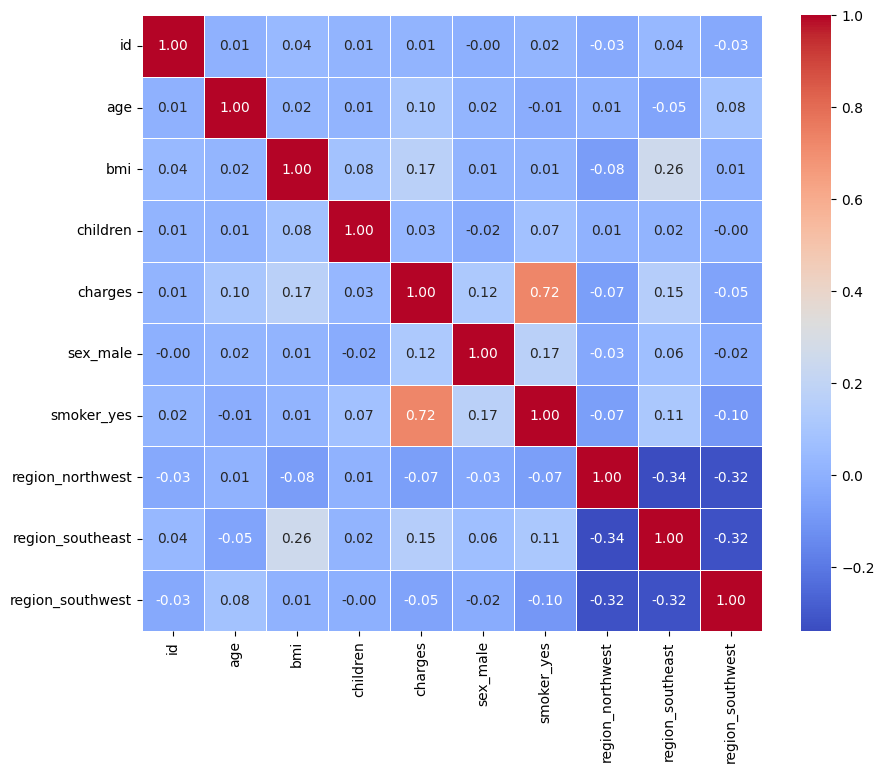

In [ ]:
# 相関を調べる
corr_matrix = df_train_dummies.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)